In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from os.path import join
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.tree import export_graphviz
import pydot

In [1]:
DATASET = 'SEASON'
# DATASET = 'TEAM'
VAL_ON_END = True  # False = Start. False would mean validate on starting season's data

# How to use this notebook

Change `DATASET` and `VAL_ON_END` variable to test the dataset you want.
For explanation of `SEASON` and `TEAM` read notebook `3-modeling-prep.ipynb`

In [15]:
if DATASET == 'TEAM':
    train = pd.read_csv('../data/train_team.csv')
    test = pd.read_csv('../data/test_team.csv')

if DATASET == 'SEASON':
    train = pd.read_csv('../data/train_season.csv')
    test = pd.read_csv('../data/test_season.csv')
    
if VAL_ON_END:
    # To validate on data of the last season's, in the training-set
    train, validation = train_test_split(train, train_size=0.8, shuffle=False)
else:
    # To validate on data of the starting season's, in the training-set
    validation, train = train_test_split(train, train_size=0.2, shuffle=False)

In [16]:
def compute_metrics(y_true,y_pred):
    accuracy = accuracy_score(y_true,y_pred)
    f1_score_1 = f1_score(y_true,y_pred,average='binary',pos_label=1)
    f1_score_0 = f1_score(y_true,y_pred,average='binary',pos_label=0)
    f1_score_macro = f1_score(y_true,y_pred,average='macro')
    return [accuracy,f1_score_1,f1_score_0,f1_score_macro]

results = pd.DataFrame(columns=['Accuracy', 'F1-score (class 1)', 'F1-score (class 0)', 'F1-score (macro avg)'])

# Random Forrest on regualr season vs playoff

In [17]:
train.head()

,period,playoffs,shot_distance,shot_made_flag,shot_zone_basic,shot_zone_range,time_remaining,last_5_games_avg,streak_before_shot,points_before_shot,...,shot_type_2PT Field Goal,shot_type_3PT Field Goal,shot_zone_area_Back Court(BC),shot_zone_area_Center(C),shot_zone_area_Left Side Center(LC),shot_zone_area_Left Side(L),shot_zone_area_Right Side Center(RC),shot_zone_area_Right Side(R),matchup_away,matchup_home
0,3,0,0,0.0,0,0,225,0.0,0,14,...,1,0,0,1,0,0,0,0,0,1
1,3,0,0,0.0,0,0,429,0.0,2,14,...,1,0,0,1,0,0,0,0,0,1
2,3,0,14,1.0,2,1,159,0.0,0,14,...,1,0,0,0,0,0,0,1,0,1
3,3,0,20,0.0,2,2,49,0.0,1,16,...,1,0,0,0,1,0,0,0,0,1
4,4,0,8,0.0,1,1,596,0.0,0,16,...,1,0,0,1,0,0,0,0,0,1


In [18]:
test.shape

(428, 31)

In [19]:
def split_x_y(df, target):
    y = df.loc[:, [target]]
    x = df.drop([target], axis=1)
    return x, y

In [20]:
target_column = "shot_made_flag"  # y_column_name

x_train, y_train = split_x_y(train, target_column)
x_test, y_test = split_x_y(test, target_column)
x_val, y_val = split_x_y(validation, target_column)

print(f"Rows in training-set: {len(x_train)}")
print(f"Rows in validation-set: {len(x_val)}")

Rows in training-set: 1075
Rows in validation-set: 269


## READ THIS
We are using out of the bag score (oob_score) as a way to validate our model.
Instead of using validation set and introducing data leakage, with the oob_score we are estimating the validation score.
# VERIFY

In [ ]:
model_rf = RandomForestClassifier(oob_score=True).fit(x_train, y_train.values.flatten())

In [ ]:
pred = model_rf.predict(x_train)

Performing a sanity check

In [23]:
confusion_matrix(y_train, pred)

array([[584,   0],
       [  0, 491]])

In [24]:
print('OOB accuracy=', model_rf.oob_score_)

OOB accuracy= 0.6920930232558139


In [25]:
y_pred = model_rf.predict(x_val)

In [26]:
confusion_matrix(y_val, y_pred)

array([[112,  38],
       [ 57,  62]])

In [27]:
results.loc['RF-basic', :] = compute_metrics(y_val, y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-basic,0.64684,0.56621,0.702194,0.634202


# Check the tree that we generated

In [28]:
x_train.head()

,period,playoffs,shot_distance,shot_zone_basic,shot_zone_range,time_remaining,last_5_games_avg,streak_before_shot,points_before_shot,fgp_before_shot,...,shot_type_2PT Field Goal,shot_type_3PT Field Goal,shot_zone_area_Back Court(BC),shot_zone_area_Center(C),shot_zone_area_Left Side Center(LC),shot_zone_area_Left Side(L),shot_zone_area_Right Side Center(RC),shot_zone_area_Right Side(R),matchup_away,matchup_home
0,3,0,0,0,0,225,0.0,0,14,0.54,...,1,0,0,1,0,0,0,0,0,1
1,3,0,0,0,0,429,0.0,2,14,0.70,...,1,0,0,1,0,0,0,0,0,1
2,3,0,14,2,1,159,0.0,0,14,0.50,...,1,0,0,0,0,0,0,1,0,1
3,3,0,20,2,2,49,0.0,1,16,0.53,...,1,0,0,0,1,0,0,0,0,1
4,4,0,8,1,1,596,0.0,0,16,0.50,...,1,0,0,1,0,0,0,0,0,1


In [29]:
# Import tools needed for visualization

# Pull out one tree from the forest
def visualize_rf_tree(model):
    tree = model.estimators_[0]# Import tools needed for visualization
    tree = model.estimators_[0]# Export the image to a dot file
    export_graphviz(tree, out_file = 'tree.dot', feature_names = list(x_train.columns), rounded = True, precision = 1)# Use dot file to create a graph
    (graph, ) = pydot.graph_from_dot_file('tree.dot') # Write graph to a png file
    graph.write_png('tree.png')

In [30]:
visualize_rf_tree(model_rf)

FileNotFoundError: [Errno 2] "dot" not found in path.

# GridSearch

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


model = RandomForestClassifier()

ntrees = [10, 50, 75, 100, 200, 300, 400,  None]
max_depth = [3,5,8,10, 15,20,25, None] # depth is usually low
min_samples_split = [4,6]
min_samples_leaf = [4,6]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=model,
                   scoring='f1', #change the scoring to accuracy?
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth':max_depth,
                       'min_samples_split':min_samples_split,
                       'min_samples_leaf':min_samples_leaf,
                       'class_weight':balance
                   },
                   cv=None, #is 5 fold
                   return_train_score=False,
                   refit=False,
                   n_jobs=-1)

trc.fit(x_train, y_train.values.flatten())

KeyboardInterrupt: 

The best Parameters are:

In [ ]:
trc.best_params_

In [ ]:
model_rf_gs = RandomForestClassifier(**trc.best_params_)


In [207]:
model_rf_gs.fit(x_train, y_train.values.flatten())

RandomForestClassifier(class_weight='balanced', max_depth=3, min_samples_leaf=4,
                       min_samples_split=4, n_estimators=50)

In [208]:
y_pred = model_rf_gs.predict(x_val)
results.loc['RF-gridsearch', :] = compute_metrics(y_val, y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-basic,0.669145,0.586047,0.724458,0.655252
RF-gridsearch,0.66171,0.599119,0.707395,0.653257


In [209]:
confusion_matrix(y_val, y_pred)

array([[110,  40],
       [ 51,  68]])

# Check feature importance

In [210]:
model_rf_gs.feature_importances_

array([0.01031105, 0.        , 0.07449867, 0.04053358, 0.02925794,
       0.031475  , 0.01074543, 0.0065651 , 0.03011932, 0.04052452,
       0.0233907 , 0.02067602, 0.33100314, 0.14707192, 0.02951741,
       0.04628046, 0.        , 0.04488919, 0.00615346, 0.        ,
       0.01077406, 0.01067295, 0.        , 0.01589393, 0.00415724,
       0.00730724, 0.00306434, 0.00394802, 0.01102376, 0.01014553])

In [211]:
# Get numerical feature importances
importances = list(model_rf_gs.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(x_train.columns), importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: action_type_te       Importance: 0.33
Variable: opponent_te          Importance: 0.15
Variable: shot_distance        Importance: 0.07
Variable: combined_shot_type_Dunk Importance: 0.05
Variable: shot_zone_basic      Importance: 0.04
Variable: fgp_before_shot      Importance: 0.04
Variable: combined_shot_type_Jump Shot Importance: 0.04
Variable: shot_zone_range      Importance: 0.03
Variable: time_remaining       Importance: 0.03
Variable: points_before_shot   Importance: 0.03
Variable: combined_shot_type_Bank Shot Importance: 0.03
Variable: month                Importance: 0.02
Variable: weekday              Importance: 0.02
Variable: shot_zone_area_Center(C) Importance: 0.02
Variable: period               Importance: 0.01
Variable: last_5_games_avg     Importance: 0.01
Variable: streak_before_shot   Importance: 0.01
Variable: combined_shot_type_Layup Importance: 0.01
Variable: shot_type_2PT Field Goal Importance: 0.01
Variable: shot_type_3PT Field Goal Importance: 0.01
Varia

If we change the model, we would still get action_type_te as most important

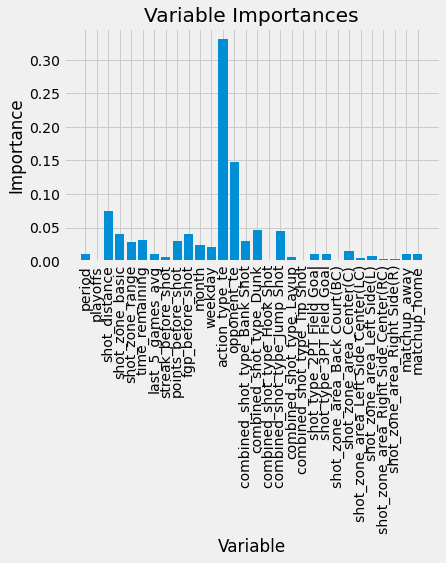

In [212]:
# Set the style
plt.style.use('fivethirtyeight')# list of x locations for plotting
x_values = list(range(len(importances)))# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')# Tick labels for x axis
plt.xticks(x_values, list(x_train.columns), rotation='vertical')# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# Run with reduced features
get only the first five top features and run the GridSearch model

In [213]:
top_features = [tuple[0] for tuple in feature_importances[:6]]

In [214]:
top_features

['action_type_te',
 'opponent_te',
 'shot_distance',
 'combined_shot_type_Dunk',
 'shot_zone_basic',
 'fgp_before_shot']

In [215]:
x_train_top = x_train.loc[:, top_features]
x_val_top = x_val.loc[:, top_features]

x_test_top = x_test.loc[:, top_features]

In [216]:
model_rf_top5 = RandomForestClassifier(**trc.best_params_)

In [217]:
model_rf_top5.fit(x_train_top, y_train.values.flatten())

RandomForestClassifier(class_weight='balanced', max_depth=3, min_samples_leaf=4,
                       min_samples_split=4, n_estimators=50)

In [218]:
y_pred = model_rf_top5.predict(x_val_top)

In [219]:
y_pred = model_rf_top5.predict(x_val_top)
results.loc['RF-gridsearch-top', :] = compute_metrics(y_val, y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

,Accuracy,F1-score (class 1),F1-score (class 0),F1-score (macro avg)
RF-gridsearch-top,0.67658,0.587678,0.733945,0.660811
RF-basic,0.669145,0.586047,0.724458,0.655252
RF-gridsearch,0.66171,0.599119,0.707395,0.653257


In [220]:
x_test.shape

(428, 30)

## Model Selected for TEAM use case (team vs PHX)

#### RF-gridsearch-top with 6 important features

Now we will run this model on 3 different test sets

In [47]:
if DATASET == 'TEAM':
    testsets = {}
    for test_file in ["test_team_04-05.csv", "test_team_05-06.csv", "test_team_09-10.csv", "test_team_15-16.csv"]:
        testsets[test_file] = pd.read_csv( join("..", "data", test_file) )
        print(f"Rows: {len( testsets[test_file] )}")

Rows: 63
Rows: 226
Rows: 170
Rows: 226


In [48]:
if DATASET == 'TEAM':
    def preprocess_data_and_run_best_model(filename, df, model, imp_features=6 ):
        x_test, y_test = split_x_y(df, target_column)
        print(f"Rows in test-set: {len(df)}")
        top_features = [tuple[0] for tuple in feature_importances[:imp_features]]
        x_test_top = x_test.loc[:, top_features]
        y_pred = model.predict(x_test_top)
        a = accuracy_score(y_test, y_pred)
        print(f"Accuracy on {filename} is: {a}")

    for filename, df in testsets.items():
        preprocess_data_and_run_best_model(filename, df, model_rf_top5, )

Rows in test-set: 63
Accuracy on test_team_04-05.csv is: 0.5555555555555556
Rows in test-set: 226
Accuracy on test_team_05-06.csv is: 0.6017699115044248
Rows in test-set: 170
Accuracy on test_team_09-10.csv is: 0.5764705882352941
Rows in test-set: 226
Accuracy on test_team_15-16.csv is: 0.6017699115044248
